Saya akan membuat model machine learning untuk masalah image processing sebagai submission akhir kelas Belajar Pengembangan Machine Learning. Pada submission kali ini saya akan menerapkan Transfer Learning dengan VGG19. Diakhir, model akan dikonversi menjadi TF-Lite untuk dapat di-deploy ke Android atau iOS.

In [ ]:
import zipfile, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adamax
from keras.preprocessing import image
from google.colab import files
%matplotlib inline
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Saya menggunakan dataset berisi gambar hewan (anjing, ayam, dan laba-laba) dengan resolusi berbeda-beda yang diunduh dari Kaggle.

In [ ]:
local_zip = '/content/drive/My Drive/dataset/chicken_dog_spider.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/chicken_dog_spider/')
zip_ref.close()

In [ ]:
base_dir = '/tmp/chicken_dog_spider/'

Saya menerapkan ImageDataGenerator seperti yang diajarkan pada kelas Belajar Machine Learning untuk Pemula di Dicoding.

In [ ]:
img_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode='nearest',
        horizontal_flip=True,
        vertical_flip=True,
        rescale=1./255,
        validation_split=0.3)

In [ ]:
train_datagen = img_datagen.flow_from_directory(
        base_dir,
        target_size=(150, 150),
        class_mode='categorical',
        batch_size=16)

test_datagen = img_datagen.flow_from_directory(
        base_dir,
        target_size=(150, 150),
        class_mode='categorical',
        batch_size=16,
        subset='validation')

Found 12782 images belonging to 3 classes.
Found 3833 images belonging to 3 classes.


Selanjutnya saya menerapkan callbacks dengan batas akurasi lebih dari atau sama dengan 92% pada training dan validation accuracy.

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') >= 0.92 and logs.get('val_accuracy') >= 0.92):
          print('\naccuracy dan val_accuracy telah mencapai 92%.')
          self.model.stop_training = True
callbacks = myCallback()

Berikut adalah arsitektur yang dibuat.

In [ ]:
model = tf.keras.models.Sequential([
    VGG19(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
model.layers[0].trainable = False

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 2, 32)          147488    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 20,174,179
Trainable params: 149,795
Non-trainable params: 20,024,384
______________________________________

In [ ]:
model.compile(optimizer=Adamax(learning_rate=0.0015), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_datagen, validation_data=test_datagen, epochs=100, verbose=1, callbacks=[callbacks])

Epoch 1/100
799/799 [==============================] - 121s 152ms/step - loss: 0.4348 - accuracy: 0.8156 - val_loss: 0.3344 - val_accuracy: 0.8682
Epoch 2/100
799/799 [==============================] - 118s 147ms/step - loss: 0.3468 - accuracy: 0.8600 - val_loss: 0.3423 - val_accuracy: 0.8555
Epoch 3/100
799/799 [==============================] - 115s 144ms/step - loss: 0.3191 - accuracy: 0.8719 - val_loss: 0.3120 - val_accuracy: 0.8766
Epoch 4/100
799/799 [==============================] - 117s 147ms/step - loss: 0.3068 - accuracy: 0.8783 - val_loss: 0.2674 - val_accuracy: 0.8928
Epoch 5/100
799/799 [==============================] - 115s 144ms/step - loss: 0.2935 - accuracy: 0.8830 - val_loss: 0.3172 - val_accuracy: 0.8677
Epoch 6/100
799/799 [==============================] - 115s 143ms/step - loss: 0.2850 - accuracy: 0.8832 - val_loss: 0.3025 - val_accuracy: 0.8763
Epoch 7/100
799/799 [==============================] - 114s 143ms/step - loss: 0.2757 - accuracy: 0.8887 - val_loss: 0

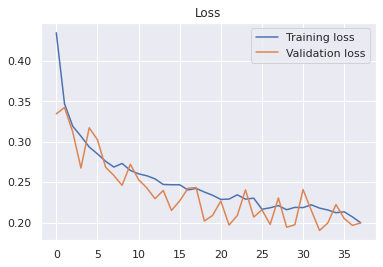

In [ ]:
plot_loss = [history.history['loss'], history.history['val_loss']]
plt.plot(range(len(plot_loss[0])), plot_loss[0], label='Training loss')
plt.plot(range(len(plot_loss[1])), plot_loss[1], label='Validation loss')
plt.title('Loss')
plt.grid(True)
plt.legend()
plt.show()

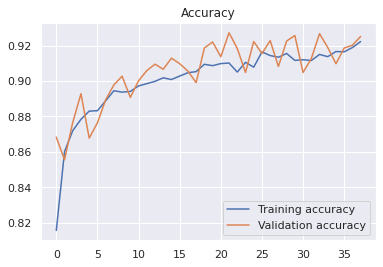

In [ ]:
plot_loss = [history.history['accuracy'], history.history['val_accuracy']]
plt.plot(range(len(plot_loss[0])), plot_loss[0], label='Training accuracy')
plt.plot(range(len(plot_loss[1])), plot_loss[1], label='Validation accuracy')
plt.title('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

Terakhir, saya akan mengkonversi model menjadi format TF-Lite seperti yang diajarkan pada modul.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpruww2i40/assets


In [ ]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)